In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 12 00:40:51 2019

@author: hanschoi
"""

# Import libraries
import datetime
import numpy as np
import glob
import os
import argparse
from dopamine.discrete_domains.unity_lib import OTCPreprocessing
from obstacle_tower_env import ObstacleTowerEnv, ActionFlattener

from stable_baselines.common.policies import MlpPolicy, CnnPolicy
from stable_baselines.common.vec_env import SubprocVecEnv
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.results_plotter import load_results, ts2xy
from stable_baselines.bench import Monitor
from stable_baselines import PPO2


In [2]:
parser = argparse.ArgumentParser(formatter_class=argparse.ArgumentDefaultsHelpFormatter)
enable_obsnorm = False
obsnorm_mode="pixel"
obsnorm_period=10000
num_cpu=2
gamma=0.999
num_iterations=50
num_timesteps=25000
learning_rate=.000625
starting_floor=0
total_floors=10
starting_workerid=np.random.randint(100, 200)
model_save_dir="models/ppo/"
model_filename="ppo_model"
verbose_learning=1
log_interval=1


In [3]:

# Create Obstacle Tower environment
def make_env(log_dir, cpu):
    sub_dir = "{}cpu_{}/".format(log_dir, cpu)
    os.makedirs(sub_dir, exist_ok=True)
    def _init():
        env_config = {"total-floors": total_floors, "dense-reward": 1, "starting-floor": starting_floor}
        env = ObstacleTowerEnv('./ObstacleTower/obstacletower', worker_id=starting_workerid+cpu + np.random.randint(100),
                               retro=True, config=env_config, greyscale=True, timeout_wait=600)
        env = OTCPreprocessing(env, enable_obsnorm=enable_obsnorm,
                               obsnorm_mode=obsnorm_mode, obsnorm_period=obsnorm_period)
        env = Monitor(env, sub_dir, allow_early_resets=True)
        return env
    return _init

def make_evalenv():
    env_config = {"total-floors": total_floors, "dense-reward": 1, "starting-floor": starting_floor}
    env = ObstacleTowerEnv('./ObstacleTower/obstacletower', worker_id=starting_workerid + np.random.randint(100),
                           retro=True, config=env_config, greyscale=True, timeout_wait=600, realtime_mode=True)
    env = OTCPreprocessing(env, enable_obsnorm=enable_obsnorm,
                           obsnorm_mode=obsnorm_mode, obsnorm_period=obsnorm_period)
    return env

def callback(_locals, _globals):
  """
  Callback called at each step (for DQN an others) or after n steps (see ACER or PPO2)
  :param _locals: (dict)
  :param _globals: (dict)
  """
  global n_steps, best_mean_reward
  # Print stats every 10000 calls
  if (n_steps + 1) % 10000 == 0:
      # Evaluate policy performance
      x, y = ts2xy(load_results(log_dir), 'timesteps')
      if len(x) > 0:
          mean_reward = np.mean(y[-100:])
          print(x[-1], 'timesteps')
          print("Best mean reward: {:.2f} - Last mean reward per episode: {:.2f}".format(best_mean_reward, mean_reward))

          # New best model, you could save the agent here
          if mean_reward > best_mean_reward:
              best_mean_reward = mean_reward
              # Example for saving best model
              print("Saving new best model")
              _locals['self'].save(log_dir + 'best_model.pkl')
  n_steps += 1
  return True

# Run episode for evaluation
def run_episode(env, model):
    done = False
    episode_reward = 0.0
    obs = env.reset()

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward


In [4]:
num_cpu = 4
model_save_dir="models/ppo/ppo_base/"
log_dir = model_save_dir + 'logs'

if model_save_dir[-1] != '/':
    model_save_dir = model_save_dir + '/'
file_prefix = model_save_dir + model_filename
if len(glob.glob(file_prefix + '_*.pkl')) > 0:
    last_checkpoint = np.sort([int(x[len(file_prefix) + 1]) for x in glob.glob(file_prefix + '_*.pkl')])[-1]

In [5]:
multienv = SubprocVecEnv([make_env(log_dir, cpu) for cpu in range(num_cpu)])

INFO:gym_unity:1 agents within environment.
INFO:gym_unity:1 agents within environment.
INFO:gym_unity:1 agents within environment.
INFO:gym_unity:1 agents within environment.


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2

In [12]:
im = multienv.reset()

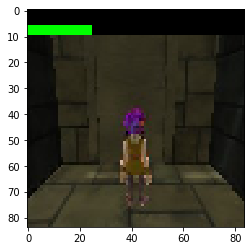

In [14]:
plt.imshow((im/255).reshape(84, 84, 3))

In [9]:
evalenv = make_evalenv()

INFO:gym_unity:1 agents within environment.


In [6]:
from stable_baselines.common.policies import MlpPolicy, CnnPolicy, CnnLstmPolicy, CnnLnLstmPolicy, LstmPolicy

In [7]:
multimodel = PPO2(CnnLstmPolicy, multienv, verbose=verbose_learning, gamma=gamma, learning_rate=learning_rate,
              tensorboard_log=log_dir)

In [7]:
multimodel = multimodel.load(file_prefix + '_{}'.format(last_checkpoint), env=multienv)

In [8]:
multimodel.learn(total_timesteps=100, log_interval=log_interval)

In [8]:
file_prefix = 'models/ppo/ppobase/ppo_model'
glob.glob(file_prefix + '_*.pkl')[0]

['models/ppo/ppobase/ppo_model_1.pkl']

In [17]:
import re
int(re.search(r"\d+(\.\d+)?", glob.glob(file_prefix + '_*.pkl')[-1][-7:]).group(0))

1

In [16]:
glob.glob(file_prefix + '_*.pkl')[-1][-7:]

'l_1.pkl'

In [17]:
run_episode(multienv, multimodel)

In [21]:
obs = multienv.reset()


In [23]:
action, _states = multimodel.predict(obs)

In [26]:
obs, reward, done, info = multienv.step(action)

In [48]:
obs[:1].shape

(1, 84, 84, 1)

In [34]:
action

array([6, 6, 3, 3])

In [ ]:
def run_episode(env, model):
    done = False
    episode_reward = 0.0
    obs = env.reset()

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward

    return episode_reward

In [1]:
import numpy as np
import os
import argparse
from obstacle_tower_env import ObstacleTowerEnv, ActionFlattener

from stable_baselines.common.policies import CnnPolicy
from stable_baselines.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines.bench import Monitor
from stable_baselines import PPO2

In [2]:
def make_env():
    def _init():
        env = ObstacleTowerEnv(args.environment_filename, docker_training=args.docker_training,
                               worker_id=999, retro=True, greyscale=True)
        env._flattener = ActionFlattener([2, 3, 2, 1])
        env._action_space = env._flattener.action_space
        return env
    return _init

def run_episode(env, model):
    done = False
    episode_reward = 0.0
    obs = env.reset()

    while not done:
        action, _states = model.predict(obs)
        obs, reward, done, info = env.step(action)
        episode_reward += reward
    return episode_reward


def run_evaluation(env):
    while not env.done_grading():
        run_episode(env)
        env.reset()


In [3]:
env = ObstacleTowerEnv('ObstacleTower/obstacletower', retro=True, greyscale=True)
env._flattener = ActionFlattener([2, 3, 2, 1])
env._action_space = env._flattener.action_space

INFO:gym_unity:1 agents within environment.


In [4]:
model = PPO2(CnnPolicy, SubprocVecEnv([lambda: env]), verbose=1, gamma=.999, learning_rate=.0000625)

ValueError: Shape must be rank 2 but is rank 4 for 'model/Slice' (op: 'Slice') with input shapes: [?,84,84,1], [2], [2].